In [74]:
# MILP model for dynamic bike rebalancing with 4 scenarios

import json
import os
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpBinary, LpStatus, value
from collections import defaultdict
import matplotlib.pyplot as plt

# === Constants ===
SCENARIOS = {
    "A": {"city": 3, "outskirts": 0},
    "B": {"city": 2, "outskirts": 1},
    "C": {"city": 1, "outskirts": 2},
    "D": {"city": 0, "outskirts": 3},
}
NUM_STATIONS = 30
TIME_SLOT = 30
TOTAL_MINUTES = 360
NUM_PERIODS = TOTAL_MINUTES // TIME_SLOT
TRUCK_CAPACITY = 5
NUM_TRUCKS = 3
STATION_CAPACITY = {s: 40 if s < 5 else 20 for s in range(NUM_STATIONS)}

def load_distance_matrix(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_initial_inventory(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return {int(k): int(v) for k, v in enumerate(data)} if isinstance(data, list) else {int(k): int(v) for k, v in data.items()}

def aggregate_demand_from_trips(data_dir, file_limit, demand_multiplier=1.2):
    rental_demand = defaultdict(int)
    return_demand = defaultdict(int)
    files = sorted([f for f in os.listdir(data_dir) if f.startswith("simu0_") and f.endswith(".json")])[:file_limit]

    for filename in files:
        with open(os.path.join(data_dir, filename), 'r') as f:
            trips = json.load(f)
        for td, sd, ta, sa in trips:
            rental_period = int(td) // TIME_SLOT
            return_period = int(ta) // TIME_SLOT
            rental_demand[(int(sd), rental_period)] += 1
            return_demand[(int(sa), return_period)] += 1

    day_count = len(files)
    f_plus = {(s, t): (rental_demand[(s, t)] / day_count) * demand_multiplier for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)}
    f_minus = {(s, t): (return_demand[(s, t)] / day_count) * demand_multiplier for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)}
    return f_plus, f_minus

def build_milp_model(f_plus, f_minus, initial_inventory, dist_matrix, scenario, lambda_dist=0.1):
    model = LpProblem("BikeRebalance", LpMinimize)

    # === Variables ===
    x_plus = LpVariable.dicts("x_plus", [(s, t) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)], lowBound=0)
    x_minus = LpVariable.dicts("x_minus", [(s, t) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)], lowBound=0)
    r_plus = LpVariable.dicts("r_plus", [(s, t, v) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS) for v in range(NUM_TRUCKS)], lowBound=0)
    r_minus = LpVariable.dicts("r_minus", [(s, t, v) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS) for v in range(NUM_TRUCKS)], lowBound=0)
    d = LpVariable.dicts("d", [(s, t) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS + 1)], lowBound=0)
    d_hat = LpVariable.dicts("d_hat", [(v, t) for v in range(NUM_TRUCKS) for t in range(NUM_PERIODS + 1)], lowBound=0)
    z = LpVariable.dicts("z", [(s, t, v) for s in range(NUM_STATIONS) for t in range(NUM_PERIODS) for v in range(NUM_TRUCKS)], cat=LpBinary)
    travel = LpVariable.dicts("travel", [(i, j, t, v) for i in range(NUM_STATIONS) for j in range(NUM_STATIONS) for t in range(NUM_PERIODS - 1) for v in range(NUM_TRUCKS)], cat=LpBinary)

    # === Objective ===
    model += (
        lpSum((f_plus[s, t] - x_plus[s, t]) + (f_minus[s, t] - x_minus[s, t])
              for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)) +
        lambda_dist * lpSum(dist_matrix[i][j] * travel[i, j, t, v]
                            for i in range(NUM_STATIONS) for j in range(NUM_STATIONS)
                            for t in range(NUM_PERIODS - 1) for v in range(NUM_TRUCKS))
    )

    # === Initial values ===
    # Assign initial truck positions based on scenario
    city_stations = list(range(5))
    outskirts_stations = list(range(5, 30))
    truck_id = 0
    assigned = set()
    for region, count in scenario.items():
        stations = city_stations if region == "city" else outskirts_stations
        for _ in range(count):
            s = next(s for s in stations if s not in assigned)
            model += z[s, 0, truck_id] == 1
            for other_s in range(NUM_STATIONS):
                if other_s != s:
                    model += z[other_s, 0, truck_id] == 0
            assigned.add(s)
            truck_id += 1
    for s in range(NUM_STATIONS):
        model += d[s, 0] == initial_inventory[s]
    for v in range(NUM_TRUCKS):
        model += d_hat[v, 0] == 0

    # === Constraints ===

    # (1) Truck location constraint: one truck per station at each time
    for v in range(NUM_TRUCKS):
        for t in range(NUM_PERIODS):
            model += lpSum(z[s, t, v] for s in range(NUM_STATIONS)) == 1

    # (2) Truck routing constraint: ensure consistency of travel and restrict region
    for v in range(NUM_TRUCKS):
        for t in range(NUM_PERIODS - 1):
            for i in range(NUM_STATIONS):
                model += lpSum(travel[i, j, t, v] for j in range(NUM_STATIONS) if (i in city_stations and j in city_stations) or (i in outskirts_stations and j in outskirts_stations)) == z[i, t, v]
                model += lpSum(travel[j, i, t, v] for j in range(NUM_STATIONS) if (i in city_stations and j in city_stations) or (i in outskirts_stations and j in outskirts_stations)) == z[i, t + 1, v]

    # (3) Successful trips cannot exceed demand
    for s in range(NUM_STATIONS):
        for t in range(NUM_PERIODS):
            model += x_plus[s, t] <= f_plus[s, t]  # rental demand
            model += x_minus[s, t] <= f_minus[s, t]  # return demand

    # (4) Inventory flow at stations
    for s in range(NUM_STATIONS):
        for t in range(NUM_PERIODS):
            model += d[s, t + 1] == d[s, t] - x_plus[s, t] + x_minus[s, t] + lpSum(r_minus[s, t, v] - r_plus[s, t, v] for v in range(NUM_TRUCKS))

    # (5) Inventory flow in vehicles
    for v in range(NUM_TRUCKS):
        for t in range(NUM_PERIODS):
            model += d_hat[v, t + 1] == d_hat[v, t] + lpSum(r_plus[s, t, v] - r_minus[s, t, v] for s in range(NUM_STATIONS))

    # (6) Rebalancing only if truck is present at station
    for s in range(NUM_STATIONS):
        for t in range(NUM_PERIODS):
            for v in range(NUM_TRUCKS):
                model += r_plus[s, t, v] + r_minus[s, t, v] <= TRUCK_CAPACITY * z[s, t, v]

    return model

def run_all_scenarios(data_dir):
    f_plus, f_minus = aggregate_demand_from_trips(data_dir, file_limit=7, demand_multiplier=1.2)
    initial_inventory = load_initial_inventory(os.path.join(data_dir, "Initial_Inven.json"))
    dist_matrix = load_distance_matrix(os.path.join(data_dir, "Dis.json"))

    all_results = {}  # Store per-scenario results

    for name, scenario in SCENARIOS.items():
        print(f"\nRunning scenario {name}...")
        model = build_milp_model(f_plus, f_minus, initial_inventory, dist_matrix, scenario)
        model.solve()
        var_dict = model.variablesDict()

        # === Compute components ===
        total_loss = value(model.objective)
        rental_loss = sum(
            f_plus[s, t] - var_dict[f"x_plus_({s},_{t})"].varValue
            for s in range(NUM_STATIONS) for t in range(NUM_PERIODS)
            if f"x_plus_({s},_{t})" in var_dict
        )
        travel_cost = 0.1 * sum(
            dist_matrix[i][j] * var_dict[f"travel_({i},_{j},_{t},_{v})"].varValue
            for i in range(NUM_STATIONS) for j in range(NUM_STATIONS)
            for t in range(NUM_PERIODS - 1) for v in range(NUM_TRUCKS)
            if f"travel_({i},_{j},_{t},_{v})" in var_dict
        )

        # Store results for this scenario
        all_results[name] = {
            "Total Loss": total_loss,
            "Rental Loss": rental_loss,
            "Travel Cost": travel_cost
        }

    # === Final summary ===
    print("\n===== Scenario Summary =====")
    print(f"{'Scenario':<10} {'Total Loss':>12} {'Rental':>10} {'Travel':>10}")
    for name, metrics in all_results.items():
        print(f"{name:<10} {metrics['Total Loss']:>12.2f} {metrics['Rental Loss']:>10.2f} {metrics['Travel Cost']:>10.2f}")

    return all_results


if __name__ == "__main__":
    data_directory = "./Dataset"
    results = run_all_scenarios(data_directory)




Running scenario A...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/Hsuweic/miniconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/j5/b206ytkd1f52lmgd91ffpq1r0000gn/T/a2c0f8c5652246b9bd0db3834e8db831-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/j5/b206ytkd1f52lmgd91ffpq1r0000gn/T/a2c0f8c5652246b9bd0db3834e8db831-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4340 COLUMNS
At line 128601 RHS
At line 132937 BOUNDS
At line 159593 ENDATA
Problem MODEL has 4335 rows, 29964 columns and 55875 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -80.0571 - 0.02 seconds
Cgl0002I 2022 variables fixed
Cgl0004I processed model has 582 rows, 1365 columns (909 integer (909 of which binary)) and 3337 elements
Cbc0038I Initial state - 52 integers unsatisfied sum - 1.88
Cbc0038I 

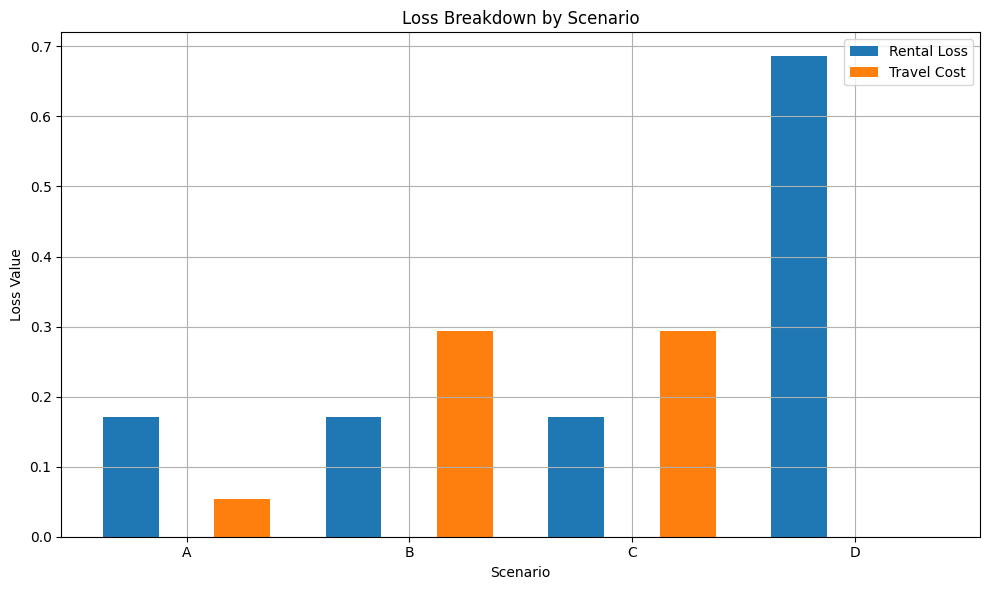

est solution, best possible -803.58644 (291.55 seconds)
Cbc0010I After 89700 nodes, 10289 on tree, -803.12236 best solution, best possible -803.58644 (291.83 seconds)
Cbc0010I After 89800 nodes, 10278 on tree, -803.12236 best solution, best possible -803.58644 (292.11 seconds)
Cbc0010I After 89900 nodes, 10277 on tree, -803.12236 best solution, best possible -803.58644 (292.40 seconds)
Cbc0010I After 90000 nodes, 10271 on tree, -803.12236 best solution, best possible -803.58644 (292.67 seconds)
Cbc0010I After 90100 nodes, 10270 on tree, -803.12236 best solution, best possible -803.58644 (292.88 seconds)
Cbc0010I After 90200 nodes, 10285 on tree, -803.12236 best solution, best possible -803.58644 (293.17 seconds)
Cbc0010I After 90300 nodes, 10269 on tree, -803.12236 best solution, best possible -803.58644 (293.41 seconds)
Cbc0010I After 90400 nodes, 10293 on tree, -803.12236 best solution, best possible -803.58644 (293.68 seconds)
Cbc0010I After 90500 nodes, 10278 on tree, -803.12236 be

In [ ]:
import matplotlib.pyplot as plt

def plot_scenario_breakdown(all_results):
    scenarios = list(all_results.keys())
    rental_losses = [all_results[sc]["Rental Loss"] for sc in scenarios]
    travel_costs = [all_results[sc]["Travel Cost"] for sc in scenarios]

    bar_width = 0.25
    x = range(len(scenarios))

    plt.figure(figsize=(10, 6))
    plt.bar([i - bar_width for i in x], rental_losses, width=bar_width, label='Rental Loss')
    plt.bar([i + bar_width for i in x], travel_costs, width=bar_width, label='Travel Cost')

    plt.xlabel("Scenario")
    plt.ylabel("Loss Value")
    plt.title("Loss Breakdown by Scenario")
    plt.xticks(ticks=x, labels=scenarios)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

plot_scenario_breakdown(results)

